In [1]:
import random
from tqdm import tqdm

import numpy as np
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch import nn, optim

from unet import UNet

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed = 42
np.random.seed = 42

In [3]:
class HairDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.img_dir + '/' + self.images[idx]
        mask_path = self.mask_dir + '/' + self.masks[idx]
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") 
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
train_dataset = HairDataset("../dataset/train/photos", "../dataset/train/masks", transform=transform)
val_dataset = HairDataset("../dataset/val/photos", "../dataset/val/masks", transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [6]:
len(train_dataset), train_dataset[0][0].shape

(840, torch.Size([3, 256, 256]))

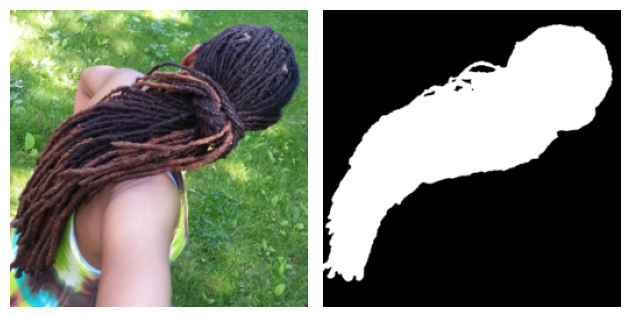

In [7]:
image_idx = random.randint(0, len(train_dataset))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(train_dataset[image_idx][0].permute(1,2,0))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(train_dataset[image_idx][1].permute(1,2,0), cmap='gray')

plt.tight_layout()
plt.show()

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()
#     epoch_loss = 0
#     for images, masks in tqdm(train_dataloader):
#         images, masks = images.to(device), masks.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)

#         loss = criterion(outputs, masks)
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}")
#     torch.save(model.state_dict(), "hair_model.pth")

# print("Done!")

In [11]:
model.load_state_dict(torch.load("weights/hair_model.pth", weights_only=True))
model.eval()

UNet(
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_3): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [12]:
def predict_mask(model, image):
    model.load_state_dict(torch.load("weights/hair_model.pth", weights_only=True))
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        return model(image.unsqueeze(0)).squeeze(0).squeeze(0).to('cpu')

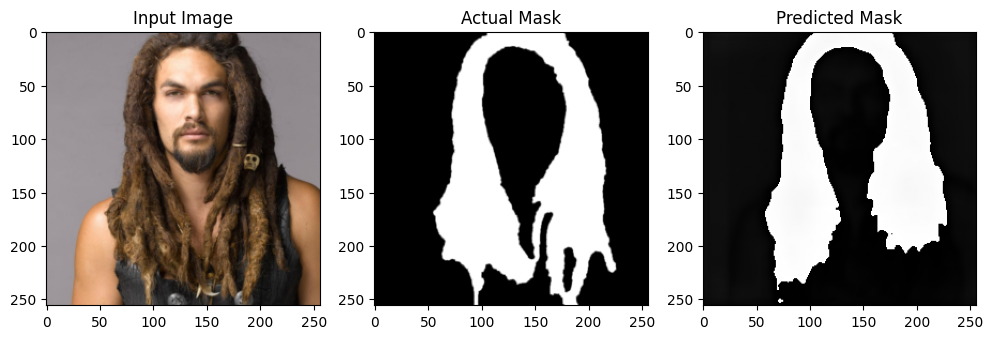

In [13]:
image_idx = random.randint(0, len(val_dataset))

x, y = val_dataset[image_idx]
output = predict_mask(model, x)

image = x.permute(1,2,0)
mask = y.permute(1,2,0)
y_mask = output.detach().numpy().astype(np.uint8)


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title('Actual Mask')
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(1 - y_mask, cmap='gray')